# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
predictions = np.array([-10, 0, 10])

probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [17]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 691.157684
Epoch 1, loss: 703.560753
Epoch 2, loss: 745.184409
Epoch 3, loss: 783.676345
Epoch 4, loss: 909.530108
Epoch 5, loss: 951.615549
Epoch 6, loss: 1103.640456
Epoch 7, loss: 831.467661
Epoch 8, loss: 865.475871
Epoch 9, loss: 855.714277


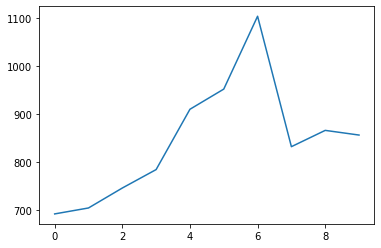

In [18]:
# let's look at the loss history!
plt.plot(loss_history)

In [19]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.159
Epoch 0, loss: 956.248279
Epoch 1, loss: 870.098427
Epoch 2, loss: 858.133043
Epoch 3, loss: 869.565176
Epoch 4, loss: 784.180407
Epoch 5, loss: 793.756808
Epoch 6, loss: 837.451760
Epoch 7, loss: 891.470045
Epoch 8, loss: 893.543102
Epoch 9, loss: 993.684889
Epoch 10, loss: 845.462690
Epoch 11, loss: 814.811378
Epoch 12, loss: 839.627846
Epoch 13, loss: 984.306639
Epoch 14, loss: 1082.855571
Epoch 15, loss: 836.566772
Epoch 16, loss: 825.703877
Epoch 17, loss: 833.015300
Epoch 18, loss: 967.631155
Epoch 19, loss: 1144.740185
Epoch 20, loss: 1153.101132
Epoch 21, loss: 866.810805
Epoch 22, loss: 812.098229
Epoch 23, loss: 764.882850
Epoch 24, loss: 724.354694
Epoch 25, loss: 731.708329
Epoch 26, loss: 737.519820
Epoch 27, loss: 766.403329
Epoch 28, loss: 810.056237
Epoch 29, loss: 849.432399
Epoch 30, loss: 1024.153706
Epoch 31, loss: 778.926374
Epoch 32, loss: 871.333416
Epoch 33, loss: 759.710143
Epoch 34, loss: 806.320775
Epoch 35, loss: 924.097807
Epoch 36, loss: 1

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [20]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for rs in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_classifier is None or accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 690.786569
Epoch 1, loss: 710.729248
Epoch 2, loss: 755.636793
Epoch 3, loss: 816.402364
Epoch 4, loss: 832.907597
Epoch 5, loss: 945.879606
Epoch 6, loss: 980.688190
Epoch 7, loss: 933.879103
Epoch 8, loss: 878.518763
Epoch 9, loss: 912.782023
Epoch 10, loss: 849.855285
Epoch 11, loss: 799.984910
Epoch 12, loss: 770.062276
Epoch 13, loss: 859.603554
Epoch 14, loss: 889.867600
Epoch 15, loss: 1055.940278
Epoch 16, loss: 1019.709467
Epoch 17, loss: 859.759542
Epoch 18, loss: 776.148348
Epoch 19, loss: 789.154751
Epoch 20, loss: 820.338818
Epoch 21, loss: 782.912168
Epoch 22, loss: 893.925104
Epoch 23, loss: 1104.218172
Epoch 24, loss: 1043.598407
Epoch 25, loss: 1059.337109
Epoch 26, loss: 937.254058
Epoch 27, loss: 1073.903243
Epoch 28, loss: 1196.595393
Epoch 29, loss: 862.143150
Epoch 30, loss: 831.288846
Epoch 31, loss: 898.992148
Epoch 32, loss: 868.149740
Epoch 33, loss: 856.823581
Epoch 34, loss: 826.156581
Epoch 35, loss: 832.345411
Epoch 36, loss: 979.202211
Epoc

Epoch 122, loss: 726.240090
Epoch 123, loss: 724.436455
Epoch 124, loss: 684.002339
Epoch 125, loss: 682.686062
Epoch 126, loss: 680.771555
Epoch 127, loss: 671.184749
Epoch 128, loss: 718.643367
Epoch 129, loss: 798.477993
Epoch 130, loss: 900.462687
Epoch 131, loss: 905.599937
Epoch 132, loss: 844.028519
Epoch 133, loss: 942.981721
Epoch 134, loss: 959.728318
Epoch 135, loss: 1051.888615
Epoch 136, loss: 1069.661379
Epoch 137, loss: 869.530708
Epoch 138, loss: 869.440639
Epoch 139, loss: 819.250269
Epoch 140, loss: 751.972451
Epoch 141, loss: 841.152464
Epoch 142, loss: 990.375751
Epoch 143, loss: 925.294580
Epoch 144, loss: 901.475358
Epoch 145, loss: 794.360548
Epoch 146, loss: 945.732315
Epoch 147, loss: 969.150512
Epoch 148, loss: 880.248849
Epoch 149, loss: 808.152203
Epoch 150, loss: 765.015651
Epoch 151, loss: 736.117605
Epoch 152, loss: 745.902774
Epoch 153, loss: 713.447593
Epoch 154, loss: 850.118467
Epoch 155, loss: 927.030578
Epoch 156, loss: 980.209537
Epoch 157, loss: 9

Epoch 42, loss: 681.623765
Epoch 43, loss: 678.845671
Epoch 44, loss: 676.895372
Epoch 45, loss: 677.355623
Epoch 46, loss: 681.465004
Epoch 47, loss: 678.655582
Epoch 48, loss: 681.392394
Epoch 49, loss: 679.796446
Epoch 50, loss: 681.828893
Epoch 51, loss: 675.527234
Epoch 52, loss: 677.748391
Epoch 53, loss: 680.581864
Epoch 54, loss: 680.805715
Epoch 55, loss: 678.545576
Epoch 56, loss: 674.631057
Epoch 57, loss: 675.999213
Epoch 58, loss: 677.270892
Epoch 59, loss: 677.973958
Epoch 60, loss: 680.351629
Epoch 61, loss: 680.589213
Epoch 62, loss: 676.656040
Epoch 63, loss: 675.730785
Epoch 64, loss: 674.886092
Epoch 65, loss: 677.968354
Epoch 66, loss: 678.662184
Epoch 67, loss: 677.345348
Epoch 68, loss: 680.052852
Epoch 69, loss: 677.040171
Epoch 70, loss: 675.459712
Epoch 71, loss: 676.165051
Epoch 72, loss: 675.056392
Epoch 73, loss: 675.757579
Epoch 74, loss: 673.796208
Epoch 75, loss: 674.083797
Epoch 76, loss: 677.743150
Epoch 77, loss: 676.763112
Epoch 78, loss: 672.665732
E

Epoch 167, loss: 664.196231
Epoch 168, loss: 669.690756
Epoch 169, loss: 662.778929
Epoch 170, loss: 672.228420
Epoch 171, loss: 656.481471
Epoch 172, loss: 665.347117
Epoch 173, loss: 663.625516
Epoch 174, loss: 670.177294
Epoch 175, loss: 662.379534
Epoch 176, loss: 666.249867
Epoch 177, loss: 668.025277
Epoch 178, loss: 666.008449
Epoch 179, loss: 659.510013
Epoch 180, loss: 672.271276
Epoch 181, loss: 660.778259
Epoch 182, loss: 668.671290
Epoch 183, loss: 661.779201
Epoch 184, loss: 663.781281
Epoch 185, loss: 672.087134
Epoch 186, loss: 662.364593
Epoch 187, loss: 661.831561
Epoch 188, loss: 660.965862
Epoch 189, loss: 664.119469
Epoch 190, loss: 668.576512
Epoch 191, loss: 661.413926
Epoch 192, loss: 662.838376
Epoch 193, loss: 661.551681
Epoch 194, loss: 651.691865
Epoch 195, loss: 657.528919
Epoch 196, loss: 659.658112
Epoch 197, loss: 656.437080
Epoch 198, loss: 666.549064
Epoch 199, loss: 659.973618
Epoch 0, loss: 690.769316
Epoch 1, loss: 691.139564
Epoch 2, loss: 690.84215

Epoch 82, loss: 689.377263
Epoch 83, loss: 689.331229
Epoch 84, loss: 689.408670
Epoch 85, loss: 687.375312
Epoch 86, loss: 687.890008
Epoch 87, loss: 689.706983
Epoch 88, loss: 688.495426
Epoch 89, loss: 689.213968
Epoch 90, loss: 688.129759
Epoch 91, loss: 687.100902
Epoch 92, loss: 687.746772
Epoch 93, loss: 689.090863
Epoch 94, loss: 689.357629
Epoch 95, loss: 688.618130
Epoch 96, loss: 688.452554
Epoch 97, loss: 687.778261
Epoch 98, loss: 688.688619
Epoch 99, loss: 687.985034
Epoch 100, loss: 687.494166
Epoch 101, loss: 687.113796
Epoch 102, loss: 687.276572
Epoch 103, loss: 688.120172
Epoch 104, loss: 688.906720
Epoch 105, loss: 687.431673
Epoch 106, loss: 688.416608
Epoch 107, loss: 687.020228
Epoch 108, loss: 687.545914
Epoch 109, loss: 687.007532
Epoch 110, loss: 688.856963
Epoch 111, loss: 688.047572
Epoch 112, loss: 686.270951
Epoch 113, loss: 688.404813
Epoch 114, loss: 686.957024
Epoch 115, loss: 686.925743
Epoch 116, loss: 687.704501
Epoch 117, loss: 686.820073
Epoch 118,

Epoch 0, loss: 690.731024
Epoch 1, loss: 690.364255
Epoch 2, loss: 691.020722
Epoch 3, loss: 690.332240
Epoch 4, loss: 690.796469
Epoch 5, loss: 690.621424
Epoch 6, loss: 690.280909
Epoch 7, loss: 690.869273
Epoch 8, loss: 690.610089
Epoch 9, loss: 690.948737
Epoch 10, loss: 690.018647
Epoch 11, loss: 690.535839
Epoch 12, loss: 690.311756
Epoch 13, loss: 690.640035
Epoch 14, loss: 690.275191
Epoch 15, loss: 689.995977
Epoch 16, loss: 690.165229
Epoch 17, loss: 690.058429
Epoch 18, loss: 689.960320
Epoch 19, loss: 690.237490
Epoch 20, loss: 690.022485
Epoch 21, loss: 689.657112
Epoch 22, loss: 689.914703
Epoch 23, loss: 689.303660
Epoch 24, loss: 690.900574
Epoch 25, loss: 689.420412
Epoch 26, loss: 689.915987
Epoch 27, loss: 689.911357
Epoch 28, loss: 689.628574
Epoch 29, loss: 689.813756
Epoch 30, loss: 689.115493
Epoch 31, loss: 689.835999
Epoch 32, loss: 689.380054
Epoch 33, loss: 688.611926
Epoch 34, loss: 689.767796
Epoch 35, loss: 690.062862
Epoch 36, loss: 690.858894
Epoch 37, l

# Какой же точности мы добились на тестовых данных?

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.192000
